<a href="https://colab.research.google.com/github/Chuequi/Practica_NLP-KeepCoding_Bootcamp_BD_IX/blob/main/Practica_NLP___Alejandro_Zegalo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

%%html
<marquee style='width: 30%; color: green;'><b>Bienvenidos a la pr√°ctica!</b></marquee>

# **Importamos algunas librer√≠as** 

In [ ]:
import json
import pandas as pd
import numpy as np

from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist

from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec

from sklearn.manifold import TSNE

from wordcloud import WordCloud
%matplotlib inline

# **1.- Descarga y exploraci√≥n del corpus**

## Carga de los Datos

Me gustan los videojuegos, as√≠ que descargar√© el dataset de videogames

In [ ]:
! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz

--2022-06-30 20:58:40--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113104579 (108M) [application/x-gzip]
Saving to: ‚Äòreviews_Video_Games_5.json.gz‚Äô

reviews_Video_Games 100%[===================>] 107.86M  14.1MB/s    in 11s     

2022-06-30 20:58:51 (9.56 MB/s) - ‚Äòreviews_Video_Games_5.json.gz‚Äô saved [113104579/113104579]



In [ ]:
! gunzip -k reviews_Video_Games_5.json.gz

In [ ]:
! head reviews_Video_Games_5.json

{"reviewerID": "A2HD75EMZR8QLN", "asin": "0700099867", "reviewerName": "123", "helpful": [8, 12], "reviewText": "Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be \"unlocked\" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don't like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I'm really tired of arcade style rally/racing games anyway.I'll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful.", "overall": 1.0, "summary": "Pay to unlock content? I don't think so.", "unixReviewTime": 1341792000, "r

In [ ]:
import pandas as pd

data = pd.read_json("reviews_Video_Games_5.json.gz", lines=True, compression='gzip')
data.head(5)


reviewerID        asin                        reviewerName  helpful  \
0  A2HD75EMZR8QLN  0700099867                                 123  [8, 12]   
1  A3UR8NLLY1ZHCX  0700099867  Alejandro Henao "Electronic Junky"   [0, 0]   
2  A1INA0F5CWW3J4  0700099867          Amazon Shopper "Mr.Repsol"   [0, 0]   
3  A1DLMTOTHQ4AST  0700099867                            ampgreen  [7, 10]   
4  A361M14PU2GUEG  0700099867        Angry Ryan "Ryan A. Forrest"   [2, 2]   

                                          reviewText  overall  \
0  Installing the game was a struggle (because of...        1   
1  If you like rally cars get this game you will ...        4   
2  1st shipment received a book instead of the ga...        1   
3  I got this version instead of the PS3 version,...        3   
4  I had Dirt 2 on Xbox 360 and it was an okay ga...        4   

                                           summary  unixReviewTime  \
0         Pay to unlock content? I don't think so.      1341792000   
1                                  Good rally game      1372550400   
2                                        Wrong key      1403913600   
3  awesome game, if it did not crash frequently !!      1315958400   
4                                           DIRT 3      1308009600   

    reviewTime  
0   07 9, 2012  
1  06 30, 2013  
2  06 28, 2014  
3  09 14, 2011  
4  06 14, 2011

In [ ]:
data.shape

(231780, 9)

Vamos a tomar un subset de los datos para que no nos reviente la RAM

In [ ]:
from IPython.display import Image
Image(url='https://i.gifer.com/kET.gif')

Conozco las columnas de los datasets

In [ ]:
data = data[:5000]
# Data_Cells = Data_Cells.iloc[0:6000]

In [ ]:
data.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

Concateno los 2 dataset para formar 1

In [ ]:
# Me quedo solo con las columnas de texto de las reviews y el n√∫mero de estrellas

data = data[['reviewText','overall']]
data.head(10)

reviewText  overall
0  Installing the game was a struggle (because of...        1
1  If you like rally cars get this game you will ...        4
2  1st shipment received a book instead of the ga...        1
3  I got this version instead of the PS3 version,...        3
4  I had Dirt 2 on Xbox 360 and it was an okay ga...        4
5  Overall this is a well done racing game, with ...        4
6  Loved playing Dirt 2 and I thought the graphic...        5
7  I can't tell you what a piece of dog**** this ...        1
8  I initially gave this one star because it was ...        4
9  I still haven't figured this one out. Did ever...        2

In [ ]:
data.shape

(5000, 2)

**En teor√≠a no deber√≠a haber datos faltantes, pero por las dudas comprobemos**

In [ ]:
data.isnull().any()

reviewText    False
overall       False
dtype: bool

In [ ]:
data.isna().sum()

reviewText    0
overall       0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  5000 non-null   object
 1   overall     5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


# Cardinalidad del vocabulario


In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

total_palabras = []
for i in data.index:
  total_palabras.append(data['reviewText'][i])
words_str = str(total_palabras)
words = words_str.lower().split()
cont = Counter(words)
print("Tenemos {} tokens en nuestro dataset".format(len(cont)))

Tenemos 67824 tokens en nuestro dataset


In [ ]:
most_common = cont.most_common(10)
most_common

[('the', 53084),
 ('and', 27408),
 ('to', 23924),
 ('a', 23391),
 ('of', 20122),
 ('is', 17831),
 ('you', 17056),
 ('i', 13513),
 ('game', 13456),
 ('it', 12515)]

In [ ]:
words_common = [w[0] for w in most_common]
freq = [w[1] for w in most_common]

In [ ]:
freq, words_common = zip(*sorted(zip(freq, words_common)))

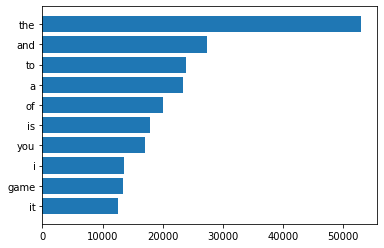

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.barh(words_common, freq)
plt.show()

**Obviamente, las palabras con m√°s frecuencia son stopwords**

In [ ]:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=ed5385db697087685130701b117967518f6e79f994881a7c26f296363d753879
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [ ]:
from stop_words import get_stop_words

sw = get_stop_words(language="en")
sw[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']

In [ ]:
words_clean = [ word for word in words if word not in sw ]  

In [ ]:
words_clean_cont = Counter(words_clean)
words_clean_common = words_clean_cont.most_common(10)
words_clean_common

[('game', 13456),
 ('can', 4344),
 ('one', 3873),
 ('like', 3823),
 ('get', 3510),
 ('just', 3255),
 ('games', 3235),
 ('will', 2789),
 ('play', 2663),
 ('great', 2191)]

**Claramente, la palabra m√°s com√∫n en un dataset de reviews de juegos es "game"**

In [ ]:
words_clean_common_graph = [x[0] for x in words_clean_common]
freq_clean = [x[1] for x in words_clean_common]

In [ ]:
freq_clean, words_clean_common_graph = zip(*sorted(zip(freq_clean, words_clean_common_graph)))

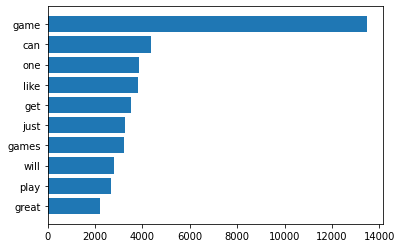

In [ ]:
plt.barh(words_clean_common_graph, freq_clean)
plt.show()

# Distribuci√≥n de reviews por n√∫mero de estrellas

In [ ]:
frequency = data.groupby(['overall']).count()
print(frequency)

         reviewText
overall            
1               203
2               219
3               472
4              1066
5              3040


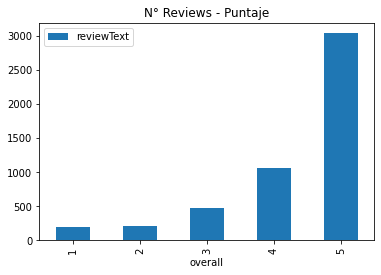

In [ ]:
frequency.plot(kind='bar', title='N¬∞ Reviews - Puntaje')

Muchos juegos buenos, deben ser reviews viejas porque los √∫ltimos juegos vienen saliendo bastante malos

# N¬∫ de reviews positivas y negativas


Clasificamos Overall (Valoraciones)

**Negativas** (0): 1,2 y 3 estrellas
**Positivas** (1): 4 y 5 estrellas

In [ ]:
set(data['overall'])

{1, 2, 3, 4, 5}

In [ ]:
data.head(5)

reviewText  overall
0  I bought this game back in December. I played ...        2
1  I've owned a copy of the original T.A. almost ...        5
2  This game actually scared me a couple times, a...        4
3  Some games (such as The Sims) are addictive at...        5
4  This game was okay - it could've been better. ...        4

Clasifico las estrellas en dos grupos

In [ ]:
def sentimientos(row):
    if int(row['overall']) < 4:
        return 0
    else:
        return 1

In [ ]:
data['Sentimiento'] = data.apply(lambda row: sentimientos(row), axis=1)

In [ ]:
data.head(5)

reviewText  overall  Sentimiento
0  I bought this game back in December. I played ...        2            0
1  I've owned a copy of the original T.A. almost ...        5            1
2  This game actually scared me a couple times, a...        4            1
3  Some games (such as The Sims) are addictive at...        5            1
4  This game was okay - it could've been better. ...        4            1

In [ ]:
#Conozco la frecuencia de reviews por estrellas
f_sentimento = data.groupby(['Sentimiento']).count()
print(f_sentimento)

             reviewText  overall
Sentimiento                     
0                   894      894
1                  4106     4106


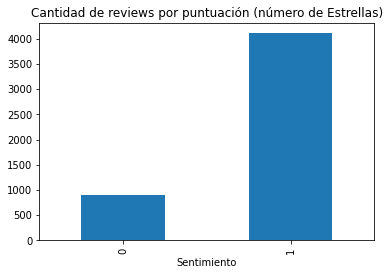

In [ ]:
f_sentimento["overall"].plot(kind='bar', title='Cantidad de reviews por puntuaci√≥n (n√∫mero de Estrellas)')

# N-grams m√°s frecuentes


In [ ]:
from nltk import ngrams
from nltk.probability import FreqDist

In [ ]:
bigramas = list(ngrams(words, 2))
trigramas = list(ngrams(words, 3))

In [ ]:
len(bigramas)

953375

In [ ]:
len(trigramas)

953374

In [ ]:
bigramas[:15]

[("['i", 'bought'),
 ('bought', 'this'),
 ('this', 'game'),
 ('game', 'back'),
 ('back', 'in'),
 ('in', 'december.'),
 ('december.', 'i'),
 ('i', 'played'),
 ('played', 'it'),
 ('it', 'for'),
 ('for', 'about'),
 ('about', '2'),
 ('2', 'solid'),
 ('solid', 'hours.'),
 ('hours.', 'i')]

In [ ]:
trigramas[:15]

[("['i", 'bought', 'this'),
 ('bought', 'this', 'game'),
 ('this', 'game', 'back'),
 ('game', 'back', 'in'),
 ('back', 'in', 'december.'),
 ('in', 'december.', 'i'),
 ('december.', 'i', 'played'),
 ('i', 'played', 'it'),
 ('played', 'it', 'for'),
 ('it', 'for', 'about'),
 ('for', 'about', '2'),
 ('about', '2', 'solid'),
 ('2', 'solid', 'hours.'),
 ('solid', 'hours.', 'i'),
 ('hours.', 'i', 'come')]

In [ ]:
bg_f = FreqDist(bigramas)
tg_f = FreqDist(trigramas)

In [ ]:
#Bigramas m√°s frecuentes
bg_f.most_common(15)

[(('of', 'the'), 5616),
 (('this', 'game'), 4365),
 (('the', 'game'), 3665),
 (('in', 'the'), 3070),
 (('if', 'you'), 2344),
 (('is', 'a'), 2337),
 (('game', 'is'), 2312),
 (('you', 'can'), 2187),
 (('and', 'the'), 2138),
 (('to', 'the'), 1960),
 (('on', 'the'), 1645),
 (('it', 'is'), 1638),
 (('is', 'the'), 1616),
 (('the', 'best'), 1596),
 (('for', 'the'), 1586)]

In [ ]:
#Trigramas m√°s frecuentes
tg_f.most_common(15)

[(('this', 'game', 'is'), 1092),
 (('one', 'of', 'the'), 980),
 (('the', 'game', 'is'), 629),
 (('a', 'lot', 'of'), 623),
 (('you', 'have', 'to'), 552),
 (('of', 'the', 'best'), 487),
 (('some', 'of', 'the'), 460),
 (('the', 'graphics', 'are'), 458),
 (('this', 'is', 'a'), 407),
 (('is', 'one', 'of'), 396),
 (('of', 'the', 'game'), 389),
 (('in', 'the', 'game'), 288),
 (('in', 'this', 'game'), 282),
 (('if', 'you', 'are'), 258),
 (('this', 'is', 'the'), 256)]

In [ ]:
bigrams_f_mas_comunes = bg_f.most_common(15)
bg_s = [str(bg[0]) for bg in bigrams_f_mas_comunes]
bgs_f = [bg[1] for bg in bigrams_f_mas_comunes]

trigrams_f_mas_comunes = tg_f.most_common(15)
tg_s = [str(tg[0]) for tg in trigrams_f_mas_comunes]
tgs_f = [tg[1] for tg in trigrams_f_mas_comunes]

In [ ]:
bgs_f, bg_s = zip(*sorted(zip(bgs_f, bg_s)))
tgs_f, tg_s = zip(*sorted(zip(tgs_f, tg_s)))

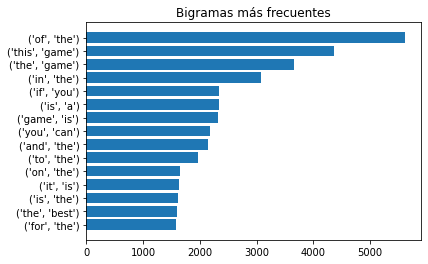

In [ ]:
plt.barh(bg_s, bgs_f)
plt.title('Bigramas m√°s frecuentes')
plt.show()

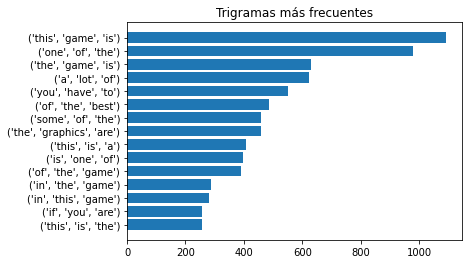

In [ ]:
plt.barh(tg_s, tgs_f)
plt.title('Trigramas m√°s frecuentes')
plt.show()

**Ahora sin stopwords**

In [ ]:
bigramas_clean = list(ngrams(words_clean, 2))
trigramas_clean = list(ngrams(words_clean, 3))

In [ ]:
len(bigramas_clean)

522027

In [ ]:
len(trigramas_clean)

522026

In [ ]:
bigramas_clean[:15]

[("['i", 'bought'),
 ('bought', 'game'),
 ('game', 'back'),
 ('back', 'december.'),
 ('december.', 'played'),
 ('played', '2'),
 ('2', 'solid'),
 ('solid', 'hours.'),
 ('hours.', 'come'),
 ('come', 'realize'),
 ('realize', 'it.'),
 ('it.', 'levels'),
 ('levels', 'like'),
 ('like', 'this.'),
 ('this.', 'boring')]

In [ ]:
trigramas_clean[:15]

[("['i", 'bought', 'game'),
 ('bought', 'game', 'back'),
 ('game', 'back', 'december.'),
 ('back', 'december.', 'played'),
 ('december.', 'played', '2'),
 ('played', '2', 'solid'),
 ('2', 'solid', 'hours.'),
 ('solid', 'hours.', 'come'),
 ('hours.', 'come', 'realize'),
 ('come', 'realize', 'it.'),
 ('realize', 'it.', 'levels'),
 ('it.', 'levels', 'like'),
 ('levels', 'like', 'this.'),
 ('like', 'this.', 'boring'),
 ('this.', 'boring', 'like')]

In [ ]:
bg_clean = FreqDist(bigramas_clean)
tg_clean = FreqDist(trigramas_clean)

In [ ]:
#Bigramas m√°s frecuentes
bg_clean.most_common(15)

[(('final', 'fantasy'), 623),
 (('one', 'best'), 384),
 (('resident', 'evil'), 342),
 (('game', 'ever'), 264),
 (('can', 'get'), 239),
 (('"this', 'game'), 225),
 (('video', 'game'), 220),
 (('game', 'play'), 215),
 (('super', 'mario'), 210),
 (('can', 'play'), 206),
 (('great', 'game'), 202),
 (('play', 'game'), 201),
 (('even', 'though'), 195),
 (('best', 'game'), 194),
 (('game', 'will'), 191)]

In [ ]:
#Trigramas m√°s frecuentes
tg_clean.most_common(15)

[(('one', 'best', 'games'), 113),
 (('super', 'mario', '64'), 72),
 (('final', 'fantasy', 'vii'), 69),
 (('metal', 'gear', 'solid'), 69),
 (('best', 'games', 'ever'), 61),
 (('best', 'game', 'ever'), 61),
 (('game', 'boy', 'color'), 48),
 (('resident', 'evil', '2'), 46),
 (('final', 'fantasy', 'viii'), 45),
 (('game', 'ever', 'played'), 44),
 (('super', 'mario', 'bros.'), 42),
 (('final', 'fantasy', '7'), 37),
 (('final', 'fantasy', 'game'), 34),
 (('street', 'fighter', 'alpha'), 33),
 (('first', 'time', 'played'), 33)]

In [ ]:

bg_s_clean = [str(bg[0]) for bg in bg_clean.most_common(15) ]
bgs_f_clean = [bg[1] for bg in bg_clean.most_common(15) ]

tg_s_clean = [str(tg[0]) for tg in tg_clean.most_common(15)]
tgs_f_clean = [tg[1] for tg in tg_clean.most_common(15)]

In [ ]:
bgs_f_clean, bg_s_clean = zip(*sorted(zip(bgs_f_clean, bg_s_clean)))
tgs_f_clean, tg_s_clean = zip(*sorted(zip(tgs_f_clean, tg_s_clean)))

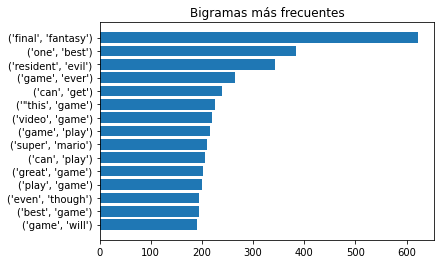

In [ ]:
plt.barh(bg_s_clean, bgs_f_clean)
plt.title('Bigramas m√°s frecuentes')
plt.show()

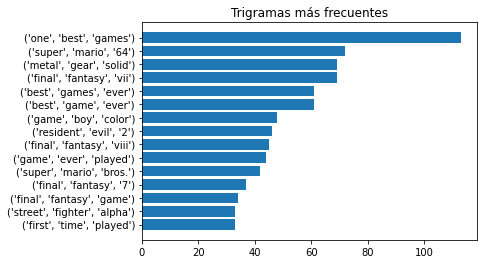

In [ ]:
plt.barh(tg_s_clean, tgs_f_clean)
plt.title('Trigramas m√°s frecuentes')
plt.show()

# Nubes de palabras


In [ ]:
from wordcloud import WordCloud


In [ ]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(' '.join(text))
    plt.figure( figsize=(16,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

**Primero hacemos la nube de palabras CON stopwords (de la variable "words"), luego SIN stopwords (de la variable "words_clean")**

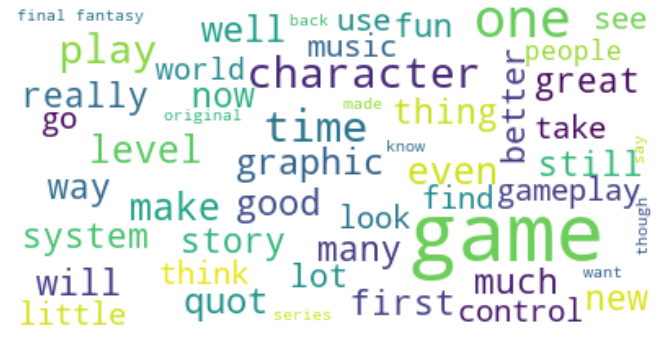

In [ ]:
plot_word_cloud(words)

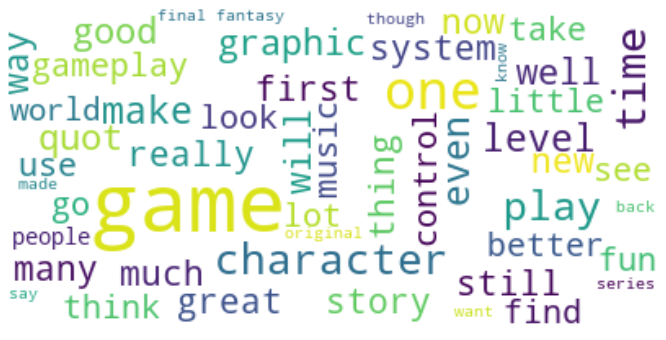

In [ ]:
plot_word_cloud(words_clean)

**Obviamente, en ambos casos la palabra m√°s significativa es "game". Tomar√© algunas de las que aparecen aqu√≠ para testear el Word2Vec en la siguiente secci√≥n.**

# Visualizaci√≥n en 2 dimensiones de algunos word embeddings calculados con Word2Vec 
(Elegir 4-5 palabras y pintar las top 10 m√°s similares)


Hyperpar√°metros:

**Size:** Ser√° la longitud de nuestro vector que representa la palabra. Cuanto m√°s grande sea este tama√±o de vector, mejor, porque m√°s √∫nica va a ser la representaci√≥n que tengamos de esa palabra en el espacio.

Sin embargo, si tenemos un vocabulario muy reducido, no hace falta que utilicemos un tama√±o tan alto. Para no a√±adir complejidad al modelo.

**Window**: La ventana lo que establece es el n√∫mero de palabras que va a tener en cuenta alrededor suya. El tama√±o tambi√©n depender√° del corpus que tengamos.

**min_count:** toma en cuenta la frecuencia m√≠nima de una palabra para que la aparezca o no en la representaci√≥n vectorial.

**sg:** para seleccionar el algoritmo con el que vamos a trabajar. 
  - Skip Gram: Lo que hace es que durante el entrenamiento, el modelo tratar√° de predecir el contexto (palabras-contexto) a una palabra dada. La palabra de entrada ser√° la palabra dada y las de salida ser√°n el contexto. 
  - CBOW: Es un m√©todo de entrenamiento que lo que hace es adivinar cu√°l es la palabra que quiere predecir. Le damos el contexto, pero la palabra actual la omite, porque es lo que tiene que predecir. As√≠ optimiza. Rellena los huecos e las frases prediciendo las palabras que podr√≠an ir en ese hueco.

**hs:** seleccionamos si vamos a utilizar softmax jer√°rquica para optimizar o un negative sampling (para optimizar los entrenamientos y evitar un overfiting de los modelos, lo que hace es que omite de forma aleatoria, a lo largo del entrenamiento, las palabras que son muy comunes en los textos).

**negative:** El valor indica el n√∫mero de "palabras ruidosas" se incluir√°n (usual entre 5-20 para datasets peque√±os, entre 2-5 para datasets grandes).





In [ ]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import numpy as np

In [ ]:
corpus = data['reviewText'].str.split()

**Probar√© un par de par√°metros distintos en ambos modelos (y los mantendr√© similares en ambos como para poder hacer una especie de comparaci√≥n) partiendo de los par√°metros que utilizamos en clases. Si bien el dataset no es muy grande, tampoco me parece peque√±o. Me falta tener esa noci√≥n de qu√© se considera "pocas palabras".**

In [ ]:
parametros = {
    'size': 500,
    'window': 20,
    'min_count': 5,
    'sg': 1,
    'hs': 0,
    'negative': 20
}

In [ ]:
Word2Vec_sg = Word2Vec(**parametros)
Word2Vec_sg.build_vocab(corpus)
print('El vocabulario est√° compuesto por {} palabras'.format(len(Word2Vec_sg.wv.vocab)))

El vocabulario est√° compuesto por 11098 palabras


In [ ]:
#Entrenamos los pesos de los embeddings
Word2Vec_sg.train(sentences=corpus, total_examples=Word2Vec_sg.corpus_count, epochs=4)

(2596223, 3813504)

In [ ]:
#Por si queremos guardar el modelo
# Word2Vec_sg.save('./w2v_sg_w12.pkl')

In [ ]:
# Para cargar un modelo guardado
# Word2Vec_sg = Word2Vec.load('./w2v_sg_w12.pkl')

Crear√© un modelo con CBOW para comparar los resultados de las palabras m√°s similares

In [ ]:
cbow_params = {
    'size': 500,
    'window': 20,
    'min_count': 5,
    'sg': 0,
    'hs': 1,
}

In [ ]:
# CBOW
Word2Vec_cbow = Word2Vec(**cbow_params)
Word2Vec_cbow.build_vocab(corpus)
print('El vocabulario est√° compuesto por {} palabras'.format(len(Word2Vec_cbow.wv.vocab)))

El vocabulario est√° compuesto por 11098 palabras


In [ ]:
# Entrenamos el modelo CBOW
Word2Vec_cbow.train(sentences=corpus, total_examples=Word2Vec_cbow.corpus_count, epochs=4)

(2596957, 3813504)

**El CBOW entrena mucho m√°s r√°pido, como era de esperar, pero tal vez SG sea mejor para este caso en particular.**

In [ ]:
# Word2Vec_cbow.save('./w2v_cbow.pkl')

## Palabras similares

In [ ]:
def print_sim_words(word, model1, model2):
    query = "Most similar to {}".format(word) 
    print(query)
    print("-"*len(query))
    for (sim1, sim2) in zip(model1.wv.most_similar(word), model2.wv.most_similar(word)):
        print("{}:{}{:.3f}{}{}:{}{:.3f}".format(sim1[0],
                                               " "*(20-len(sim1[0])), 
                                               sim1[1], 
                                               " "*10, 
                                               sim2[0],
                                               " "*(20-len(sim2[0])),
                                               sim2[1]))
    print("\n")

**Probemos el comportamiento de los dos modelos encontrando palabras similares: La izquierda es SG, la derecha es CBOW**

In [ ]:
#Palabras similares
print_sim_words('game', Word2Vec_sg, Word2Vec_cbow)
print_sim_words('gameplay', Word2Vec_sg, Word2Vec_cbow)
print_sim_words('character', Word2Vec_sg, Word2Vec_cbow)
print_sim_words('story', Word2Vec_sg, Word2Vec_cbow)

Most similar to game
--------------------
PS.:                 0.759          game,:               0.696
replay.:             0.749          game!:               0.596
Definately:          0.742          game.:               0.552
Tachyon:             0.735          one,:                0.509
recommendations.:    0.734          while.:              0.496
Enjoy!:              0.733          title.:              0.489
nes:                 0.724          title:               0.471
rpgs:                0.723          one.:                0.460
Must:                0.723          product:             0.458
end!:                0.722          allot:               0.446


Most similar to gameplay
------------------------
visually:            0.674          gameplay,:           0.682
undeniably:          0.671          scale:               0.658
responsive,:         0.661          ambiance:            0.648
crisp,:              0.657          catchy:              0.646
choppy,:             0.6

**A mi parecer, el SG est√° dando mejores resultados**

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [ ]:
keys = ['game', 'gameplay', 'story', 'character', 'pc']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in Word2Vec_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(Word2Vec_sg.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
print(word_clusters)

[['PS.', 'replay.', 'Definately', 'Tachyon', 'recommendations.', 'Enjoy!', 'nes', 'rpgs', 'Must', 'end!'], ['visually', 'undeniably', 'responsive,', 'crisp,', 'choppy,', 'satisfying.', 'practice.', 'wonderfully.', 'scale', 'rate.'], ['plot', 'involving.', 'line', 'unravels', 'twists', 'proportions', 'details.', 'continuation', 'engaging', 'emotion'], ['character.', "character's", "characters'", 'backstory', 'traits', 'weaknesses.', 'handled', 'development.', 'evolves', 'richly'], ['dreamcast.', 'wow', 'period.', 'n64,', 'shiny', 'biased', '98', 'gamecube.', 'recommendations.', 'condition,']]


Reducimos dimensionalidad a 2D para poder representar

In [ ]:
model_2D = TSNE(perplexity=20, n_components=2, init='pca', n_iter=3500, random_state=69)

In [ ]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [ ]:
embeddings_2d = np.array(model_2D.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


Visualizaci√≥n

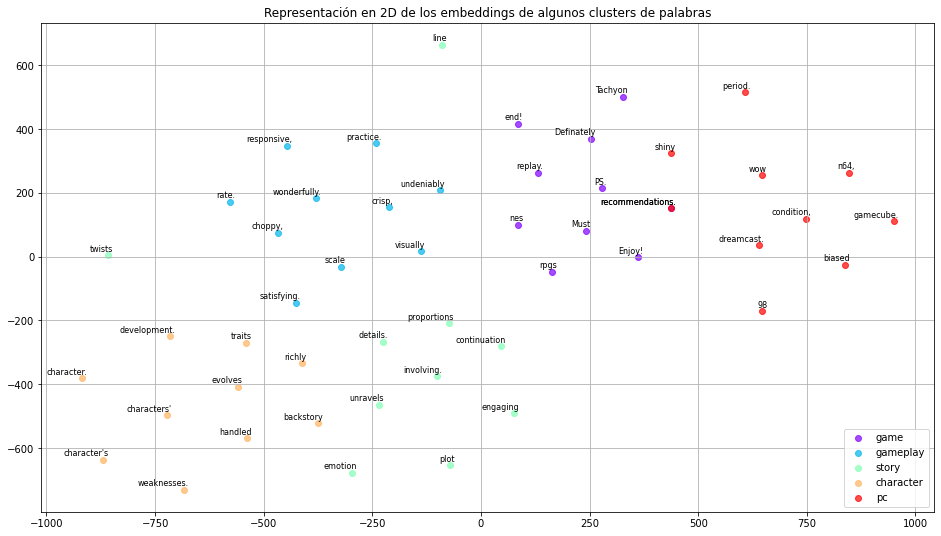

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline



def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=1, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representaci√≥n en 2D de los embeddings de algunos clusters de palabras')
    #¬†plt.savefig("f/–≥.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

**Es interesante ver c√≥mo los topics de "character" y "story" son tan cercanos, mientras que "PC" es el m√°s alejado al resto. Todo parece que tiene bastante sentido para m√≠**

# **2.- Etapa de Procesado del Texto**

In [ ]:
import nltk

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from nltk import word_tokenize, TreebankWordTokenizer, RegexpTokenizer

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
review=data['reviewText'][3]
review

"This game is so much fun! This is where it all started this game is one of the best mario parties. There's 6 characters who are arguably to this day still the most popular mario characters. There's 50 minigames and 8 fantastic boards!"

In [ ]:
!pip install num2words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 101 kB 8.9 MB/s 


In [ ]:
import unicodedata
from num2words import num2words

from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def nltk_cleaner(text, tokenizer, sw_list, lemmatizer):
    clean_text = list()
    
    # Eliminar acentos, etc
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Separar palabras eliminando signos de puntuaci√≥n
    for word in tokenizer.tokenize(text):
        
        # Eliminar stop words
        if word not in sw_list:
            
        # Eliminar espacios sobrantes, convertir a min√∫sculas y lematizar
            clean_word = lemmatizer.lemmatize(word).lower().strip()
        
        # Convertir d√≠gitos a palabras
            if clean_word.isdigit():
                clean_word = num2words(clean_word, lang='en')

            clean_text.append(clean_word)
            
    return ' '.join(clean_text)

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
sw_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
def data_cleaner(text, tokenizer, sw_list, lemmatizer):
  reviews_x = []
  for x in text:
    nltk_reviews = nltk_cleaner(x, tokenizer, sw_list, lemmatizer)
    reviews_x.append(nltk_reviews)
  return reviews_x

**Todo est√° metido en una sola funci√≥n: data_cleaner, a la que le pasamos el tokenizador, la lista de stopwords y el lematizador**

In [ ]:
data_processed = data_cleaner(data['reviewText'], tokenizer, sw_list, lemmatizer)

In [ ]:
data['reviewText'][10]

'If you want to have fun on the go, you have to get Game Boy color!! I had the old gray one before this and this is a MAJOR improvement. The colors add alot of life to the games and its backwards compatible, so you can play all the old games. The size is really convienient and the dandelion color is the best. Buy this system and pick up Game Boy camera with it too!!!'

In [ ]:
data_processed[10]

'if want fun go get game boy color i old gray one major improvement the color add alot life game backwards compatible play old game the size really convienient dandelion color best buy system pick game boy camera'

**Probamos los resultados con una review cualquiera y nos gusta el resultado**

# 3er paso  .- Etapa de entrenamiento y testeo de un modelo de an√°lisis de sentimiento

In [ ]:
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import matplotlib.pyplot as plt

Separaci√≥n en train y test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data_processed,
    data['Sentimiento'],
    train_size=0.75,
    test_size=0.25,
    random_state=69,
    shuffle=True
)

In [ ]:
X_train[:10]

['super mario sixty-four best graphic ever shown home console believe i like graphic super mario sixty-four graphic super mario sunshine sure level look great snappy tune match game way easy except bowser mario sixty-four overrated still one best game ever made it isnt best game time pack powerful punch lets hope super mario one hundred and twenty-eight even better harder challenge better graphic level i mean mario sixty-four great sequel harder i dont really want two mario game easy long enough',
 'this is one of the most enjoyable games i ve ever had the pleasure to play it is fairly simple not to mention loads of fun too there are only a few hard bosses but worth the playing time one tip always stock up on ammo and use the fountain of rejuvination always throw your drumsticks at enemies for health pickups but you get them later in the game use your crossbows for bosses and pay close attention to the books scattered thru the levels they give you clues all in all if you you want tons 

In [ ]:
y_train[:10]

736     1
4112    1
1943    0
1614    1
3170    1
4910    1
1397    1
3695    1
2198    1
4540    1
Name: Sentimiento, dtype: int64

In [ ]:
cv = TfidfVectorizer(
    ngram_range=(1, 3),
    strip_accents='ascii',
    max_df=0.95,
    min_df=3,
    max_features=3000
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=3000, min_df=3, ngram_range=(1, 3),
                strip_accents='ascii')

In [ ]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [ ]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=10000)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.816
Accuracy for C=0.05: 0.816
Accuracy for C=0.25: 0.816
Accuracy for C=0.5: 0.8184
Accuracy for C=1: 0.8328
Accuracy for C=10: 0.8608
Accuracy for C=100: 0.8424
Accuracy for C=1000: 0.836
Accuracy for C=10000: 0.8352


**C=10 es nuestro mejor accuracy, con un 0.86**

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[114 116]
 [ 90 930]]

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       230
           1       0.89      0.91      0.90      1020

    accuracy                           0.84      1250
   macro avg       0.72      0.70      0.71      1250
weighted avg       0.83      0.84      0.83      1250

Accuracy score:0.8352


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


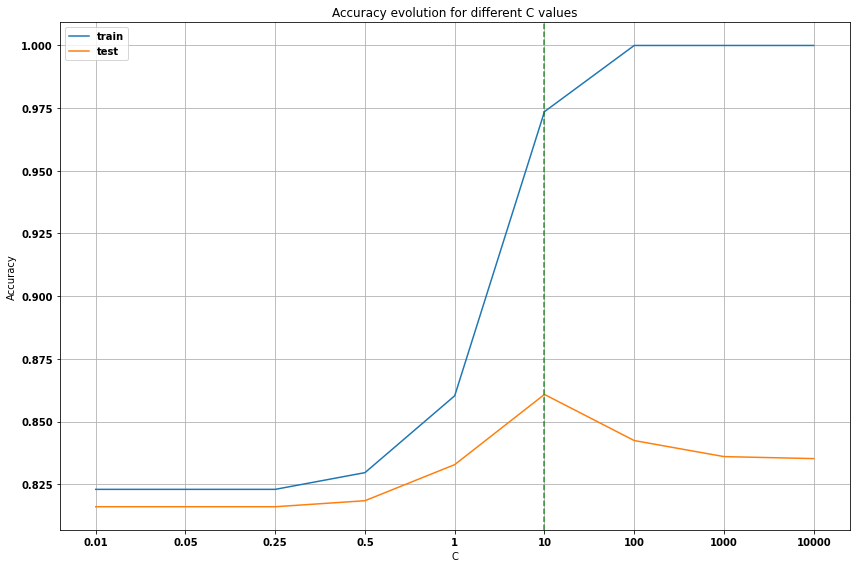

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):        
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=42)

    clf.fit(X_train, y_train)
    
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    
    return clf


clf2 = classify_gboost(X_train_, X_test_, y_train, y_test)

[GradientBoostingClassifier] Accuracy: train = 0.868, test = 0.8176


**√çnfimamente mejor que la regresi√≥n log√≠stica, una diferencia no significativa**

### Con Deep Learning

In [ ]:
# X_train_aux = X_train_.todense()
# X_test_aux = X_test_.todense()

# Esto me revienta la RAM

**Voy a utilizar la vectorizaci√≥n del TFIDF (las variables "X_train_" y "X_test_"**

In [ ]:
X_train_[0]

<1x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 74 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_aux=X_train_.toarray()
X_test_aux=X_test_.toarray()

In [ ]:
from keras.preprocessing import sequence

max_words = 3000

X_train_lstm = sequence.pad_sequences(X_train_aux, maxlen=max_words)
X_test_lstm = sequence.pad_sequences(X_test_aux, maxlen=max_words)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRUV2, SimpleRNN

vocabulary_size=5000

embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3000, 32)          160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train_lstm.shape

(3750, 3000)

In [ ]:
y_train.shape

(3750,)

In [ ]:
batch_size = 64
num_epochs = 1

X_valid, y_valid = X_train_lstm[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train_lstm[batch_size:], y_train[batch_size:]  # rest for training

model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

58/58 [==============================] - 15s 140ms/step - loss: 0.4982 - accuracy: 0.8136 - val_loss: 0.6272 - val_accuracy: 0.7344


In [ ]:
scores = model.evaluate(X_test_lstm, y_test, verbose=1)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

40/40 [==============================] - 2s 44ms/step - loss: 0.4829 - accuracy: 0.8160
Test accuracy: 0.8159999847412109


**Accuracy levemente menor que en los modelos de machine learning tradicionales. Realmente no vale la pena por todos los recursos que hay que invertir en este modelo. M√°s al respecto en las conclusiones.**

# CONCLUSIONES

En general, creo que se ha podido completar la pr√°ctica de manera satisfactoria. Aparecieron algunas dificultades en el camino, pero pensando un poco y analizando los notebooks de las clases se pudieron resolver en general, aprendiendo en el proceso. 

Esto fue hasta el momento de implementar Deep Learning. Estaba a punto de abandonar esto y dejarlo en los 2 modelos de ML hasta que por alg√∫n motivo se me ocurri√≥ pasar las variables X a arrays (con la funci√≥n toarray()). Eso, junto con cambiar la variable "vocabulary_size" de 300 a 5000 lograron que pueda hacer funcionar mi modelo, pero tengo mis dudas respecto al significado de dichos cambios. Lo que quiero decir es que en esta parte hay varios conceptos que no me quedan muy claros, y lo que hice (si bien fue una decisi√≥n razonada) me da la impresi√≥n que es "tocar algo a ver si funciona".

Tambi√©n me di cuenta de que el procesamiento de texto lo hago 2 veces: en la primera parte para hacer el an√°lisis explotatorio,  y luego en la segunda parte con la funci√≥n "data_cleaner". ¬øSe podr√≠a haber implementado esta funci√≥n primero y aprovecharla para el primero apartado de an√°lisis exploratorio? 

Una duda similar me queda en la vectorizaci√≥n/embedding: en un momento hacemos Word2Vec y luego intent√© utilizar su salida para entrenar mis modelos de machine learning, pero tuve errores y no supe c√≥mo adaptar la misma soluci√≥n, as√≠ que tom√© el camino f√°cil y utilic√© el mismo TFIDF que en la clase y funcion√≥. Siento como que me falta un poco de manejo de los m√©todos y sus variables.

Como era de esperar, creo que la mayor√≠a de problemas se dieron en la sintaxis de python y el manejo de los arrays. El primer problema en el modelo de DL era que mis X_train_ y X_test_ provenientes del TFIDF eran "Sparse Matrix" y esto no es aceptado por el padding. Sin el padding no puedo probar el modelo. Cuando busqu√© informaci√≥n, encontr√© que les deb√≠a aplicar la funci√≥n ".todense()". Esto me trajo m√°s dolores de cabeza porque me explotaba la RAM y se reiniciaba el runtime. Intentar .toarray() fue un "manotazo de ahogado" que por suerte me funcion√≥.

Una l√°stima que este √∫ltimo modelo, al ser m√°s complejo, haya dado peores resultados, pero hay varias cosas que se pueden probar: cambiar hiperpar√°metros (como el learning rate), cambiar vocabulary_size o max_words del padding (pero no s√© bien el efecto/significado de estos par√°metros) y el n√∫mero de √©pocas. Uno pensar√≠a que esto √∫ltimo tiene mucho que ver, ya que esto es DL y toma bastante tiempo, pero hice la prueba con 5 √©pocas y el accuracy no vari√≥, lo cual me desilusion√≥ mucho üòµ

En fin, trat√© de incluir una buena cantidad de comentarios para plasmar mi proceso cognitivo al momento de realizar las cosas. Espero que ayude a interpretar mejor qu√© hago y por qu√©.